# Tutorial \#5: Urban mmWave Propagation Analysis Using the NIST 28 GHz Measurement Dataset

This notebook demonstrates a complete pipeline for analyzing mmWave propagation in urban environments using:
- Real-world 28 GHz measurement data from downtown Boulder, Colorado
- RF ray tracing (Sionna RT)

## Key Components
1. **Measurement Processing**
   - MATLAB-to-Python data conversion
   - GPS/UTM coordinate transformations
   - Outdoor position validation via ray casting

2. **3D Scene Construction**
   - OSM-based building footprint generation
   - Material property assignment (ITU-R standards)
   - Transmitter/Receiver configuration

3. **Ray Tracing**

4. **Performance Analysis**
   - Sector-wise path gain comparison
   - RMSE/MAE metrics calculation
   - Indoor vs. Outdoor performance evaluation



**Prerequisites**:

Please make sure that you have properly installed Sionna:
```console
python3 -m pip install sionna
```




In [1]:
import glob
from scipy.io import loadmat

import os
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray

from sklearn.metrics import mean_squared_error, mean_absolute_error,root_mean_squared_error

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
import random

from scene_generation.core import Scene
from scene_generation.utils import rect_from_point_and_size, get_utm_epsg_code_from_gps, gps_to_utm_xy, get_center_subarray
from scene_generation.empirical_pathloss_model import pathloss_38901
from scene_generation.unet.unet_model_rt import UNet

# Mitsuba components for advanced scene operation
import mitsuba as mi
import drjit as dr

## Measurement Information

- **Dataset**: Downtown Boulder Urban Canyon Measurements
- **Source**: https://nextg.nist.gov/submissions/112
- **Data Sharing Agreement**: https://nextg.nist.gov/data_sharing_agreement

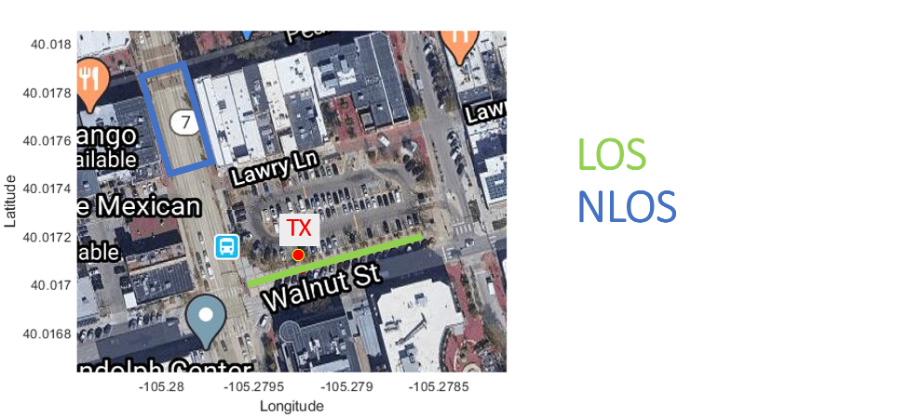
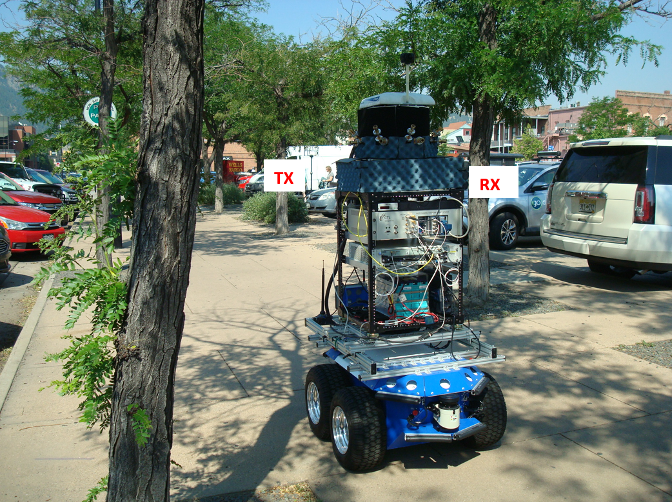

For detailed measurement information, please refer to the `data` folder.

## 1. **Processing Measurement Data**

### Measurement Configuration

Set the measurement type for analysis:
- **LOS**: Line-of-Sight measurements
- **NLOS**: Non-Line-of-Sight measurements

This configuration affects subsequent data loading and processing steps.

In [2]:
# MEASUREMENT_TYPE = "LOS"
MEASUREMENT_TYPE = "NLOS"

### Load Measurement Data: Header File 

Load and parse measurement metadata from MATLAB files containing:
- Tx/Rx GPS coordinates
- Measurement timestamps
- Antenna configuration

In [3]:
# Initialize header data structure
header_dict = {"file_name":[], "mea_idx":[]}
header_folder_path = "../data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_{}/Header files/".format(MEASUREMENT_TYPE)  
header_mat_files = glob.glob(f"{header_folder_path}/*.mat")  
print(header_mat_files[:3]) 

['../data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/Header files/F0002150hdr.mat', '../data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/Header files/F0002142hdr.mat', '../data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/Header files/F0002174hdr.mat']


In [4]:
# MATLAB to Python data conversion
for mat_file_path in header_mat_files: 

    #Load the .mat file
    data = loadmat(mat_file_path)

    # Store basic file info
    header_dict["file_name"].append(os.path.basename(mat_file_path))
    header_dict["mea_idx"].append(os.path.basename(mat_file_path)[4:4+4])

    # Recursive struct parsing
    for key in data:
        if not key.startswith("__"):  # Ignore metadata keys
            value = data[key]
            if isinstance(value, np.ndarray) and value.dtype.names:
                    for name in value.dtype.names:
                        tmp_value =  data[key][0][name]
                        try:
                            tmp_value = tmp_value.item()
                            tmp_value = tmp_value.squeeze()
                            tmp_value = tmp_value.item()
                        except Exception as e:
                            pass
                        if ("{}_{}".format(key, name)) not in header_dict:
                            header_dict[("{}_{}".format(key, name))] = []
                        header_dict[("{}_{}".format(key, name))].append(tmp_value)
            else:
                tmp_value = data[key]
                try:
                    tmp_value = tmp_value.item()
                    tmp_value = tmp_value.squeeze()
                    tmp_value = tmp_value.item()
                except Exception as e:
                    pass
                if "{}".format(key) not in header_dict:
                    header_dict[("{}".format(key))] = []
                header_dict[("{}".format(key))].append(tmp_value)

In [5]:
header_df = pd.DataFrame(header_dict)
print(header_df.iloc[0].to_string())

file_name                                                         F0002150hdr.mat
mea_idx                                                                      2150
DigData_data_sector_len                                                  41942088
DigData_data_acq_len                                                   1342168320
DigData_data_offset                                                           128
DigData_ampl_resolution                                                  0.157107
DigData_Gain                                                                   24
DigData_data_size                                                 [1, 1342168320]
DigData_sampling_period_ns                                                  0.025
DigData_sectors                                                                32
GPSData_GPGGA                   $GPGGA,163908.20,4001.047121,N,10516.798297,W,...
GPSData_GPVTG                             $GPVTG,357.5,T,,,000.65,N,001.20,K,D*41
GPSData_latitude

### Check TX Position Consistency

Critical validations:
- Single transmitter location (x, y, z) for all measurements

In [6]:
assert header_df['TxData_lat_Deg'].nunique() == 1,"Error: Mupltiple TX latitudes detected"
assert header_df['TxData_long_Deg'].nunique() == 1,"Error: Mupltiple TX longitudes detected" 
assert header_df['TxData_alt'].nunique() == 1,"Error: Mupltiple TX altitudes detected" 

### Load Measurement Data: MPC File 

Process MPC (Multi-Path Component) files containing:
- Delay (ns)
- Angle-of-arrival (AoA) in Azimuth (degree)
- Angle-of-arrival (AoA) in Elevation (degree)
- Path loss (dB)

In [7]:
# Initialize MPC data structure
MPC_dict = {"file_name":[],"mea_idx":[]}
MPC_folder_path = "../data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_{}/MPC files/".format(MEASUREMENT_TYPE)  
MPC_mat_files = glob.glob(f"{MPC_folder_path}/*.mat")  

print(MPC_mat_files[:3]) 

['../data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/MPC files/MPC2266.mat', '../data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/MPC files/MPC2267.mat', '../data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/MPC files/MPC2259.mat']


In [8]:
for mat_file_path in MPC_mat_files:   
    data = loadmat(mat_file_path)
    MPC_dict["file_name"].append(os.path.basename(mat_file_path))
    MPC_dict["mea_idx"].append(os.path.basename(mat_file_path)[3:3+4])
    for key in data:
        if not key.startswith("__"):  # Ignore metadata keys
            value = data[key]
            if isinstance(value, np.ndarray) and value.dtype.names:
                    for name in value.dtype.names:
                        tmp_value =  data[key][0][name]
                        try:
                            tmp_value = tmp_value.item()
                            tmp_value = tmp_value.squeeze()
                            tmp_value = tmp_value.item()
                        except Exception as e:
                            pass
                        if ("{}_{}".format(key, name)) not in MPC_dict:
                            MPC_dict[("{}_{}".format(key, name))] = []
                        MPC_dict[("{}_{}".format(key, name))].append(tmp_value)
            else:
                tmp_value = data[key]
                try:
                    tmp_value = tmp_value.item()
                    tmp_value = tmp_value.squeeze()
                    tmp_value = tmp_value.item()
                except Exception as e:
                    pass
                if "{}".format(key) not in MPC_dict:
                    MPC_dict[("{}".format(key))] = []
                MPC_dict[("{}".format(key))].append(tmp_value)

In [9]:
MPC_df = pd.DataFrame(MPC_dict)
print(MPC_df.iloc[0].to_string())

file_name                                                            MPC2266.mat
mea_idx                                                                     2266
header_TxGainEffective_dBi                                                     2
header_TxHPBW_Effective_deg                                                 47.3
header_dist_m                                                          61.906189
header_NumSectors                                                              8
header_B2B_Attenuation_dB                                                    -15
MPC_params_sector01            [[194.60000000000002, 133.19305332, 11.0, 129....
MPC_params_sector02            [[194.60000000000002, 127.69305331999999, 12.0...
MPC_params_sector03            [[194.625, 129.19305332, 11.5, 128.64943718814...
MPC_params_sector04            [[194.65, 127.69305331999999, 7.0, 128.4958396...
MPC_params_sector05            [[194.65, 131.19305332, 4.0, 128.0129647093495...
MPC_params_sector06         

### Dataset Integration

Combine Header and MPC for each location:
- Inner join on measurement ID (`mea_idx`)

In [10]:
merged_df = pd.merge(MPC_df, header_df, on='mea_idx', how='inner')  
print(merged_df.iloc[0].to_string())

file_name_x                                                           MPC2266.mat
mea_idx                                                                      2266
header_TxGainEffective_dBi                                                      2
header_TxHPBW_Effective_deg                                                  47.3
header_dist_m                                                           61.906189
header_NumSectors                                                               8
header_B2B_Attenuation_dB                                                     -15
MPC_params_sector01             [[194.60000000000002, 133.19305332, 11.0, 129....
MPC_params_sector02             [[194.60000000000002, 127.69305331999999, 12.0...
MPC_params_sector03             [[194.625, 129.19305332, 11.5, 128.64943718814...
MPC_params_sector04             [[194.65, 127.69305331999999, 7.0, 128.4958396...
MPC_params_sector05             [[194.65, 131.19305332, 4.0, 128.0129647093495...
MPC_params_secto

## 2. **3D Scene Generation**

Different from the CLI tools `scenegen`, here we will directly use the Python function API to generate the scene. The Python function provides more flexibility than the CLI tool for advanced use cases.

Additionally, we have updated the default radio material types to ones that are compatible with 28 GHz.

For a detailed list of radio materials supported by Siona/`scenegen`, run 
```console
$ scenegen --list-materials
```

In [11]:
scene_dir = "../scenes/Boulder_Downtown"

polygon_points_gps = rect_from_point_and_size(
    merged_df.iloc[0]["TxData_long_Deg"],
    merged_df.iloc[0]["TxData_lat_Deg"],
    "center", 
    512,
    512
)
min_lon, min_lat = polygon_points_gps[0]
max_lon, max_lat = polygon_points_gps[2]
print(
    f"Check the bbox at http://bboxfinder.com/#{min_lat:.{4}f},{min_lon:.{4}f},{max_lat:.{4}f},{max_lon:.{4}f}"
)
scene_instance = Scene()
scene_instance(
    polygon_points_gps,
    scene_dir,
    None,
    osm_server_addr="https://overpass-api.de/api/interpreter",
    lidar_calibration=False,
    generate_building_map=True,
    ground_material_type="mat-itu_concrete",
    rooftop_material_type = "mat-itu_metal",
    wall_material_type = "mat-itu_brick"
    
)

utm_epsg = get_utm_epsg_code_from_gps(
    merged_df.iloc[0]["TxData_long_Deg"],
    merged_df.iloc[0]["TxData_lat_Deg"],
)

top_left_coord_x_utm, top_left_coord_y_utm,_  =  gps_to_utm_xy(min_lon, max_lat, utm_epsg)
center_coord_x_utm, center_coord_y_utm, _ = gps_to_utm_xy(
    merged_df.iloc[0]["TxData_long_Deg"],
    merged_df.iloc[0]["TxData_lat_Deg"], 
    utm_epsg
)

Check the bbox at http://bboxfinder.com/#40.0148,-105.2823,40.0194,-105.2763


Parsing buildings: 100%|███████████████████████████████████████████| 152/152 [00:00<00:00, 581.34it/s]


### **Load and Preview** the generated scene for the target area


You can use the following controls:
* Mouse left: Rotate
* Scroll wheel: Zoom
* Mouse right: Move


In [12]:
# Replace '../scenes/Boston/scene.xml' with the path to your scene file
scene = load_scene("{}/scene.xml".format(scene_dir))

# Interative 3D visualization and view of the scene
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

### Apply the geographical coordinate system convertion 
- From GPS (EPSG:4326) to UTM
- From UTM to local (offset to the TX location)

In [13]:
# Apply transformation and store in new columns
merged_df["GPSData_longitude_UTM"], merged_df["GPSData_latitude_UTM"], _ = zip(
    *merged_df.apply(lambda row: gps_to_utm_xy(row["GPSData_longitude_Deg"], row["GPSData_latitude_Deg"], utm_epsg), axis=1)
)

merged_df["Sionna_Rx_x"], merged_df["Sionna_Rx_y"] = zip(
    *merged_df.apply(lambda row: (row["GPSData_longitude_UTM"] - center_coord_x_utm, row["GPSData_latitude_UTM"] - center_coord_y_utm ), axis=1)
)

print(merged_df.iloc[0].to_string())

file_name_x                                                           MPC2266.mat
mea_idx                                                                      2266
header_TxGainEffective_dBi                                                      2
header_TxHPBW_Effective_deg                                                  47.3
header_dist_m                                                           61.906189
header_NumSectors                                                               8
header_B2B_Attenuation_dB                                                     -15
MPC_params_sector01             [[194.60000000000002, 133.19305332, 11.0, 129....
MPC_params_sector02             [[194.60000000000002, 127.69305331999999, 12.0...
MPC_params_sector03             [[194.625, 129.19305332, 11.5, 128.64943718814...
MPC_params_sector04             [[194.65, 127.69305331999999, 7.0, 128.4958396...
MPC_params_sector05             [[194.65, 131.19305332, 4.0, 128.0129647093495...
MPC_params_secto

### Validating RX Locations in an Outdoor Environment

- Identify indoor RX locations using upward ray tracing.


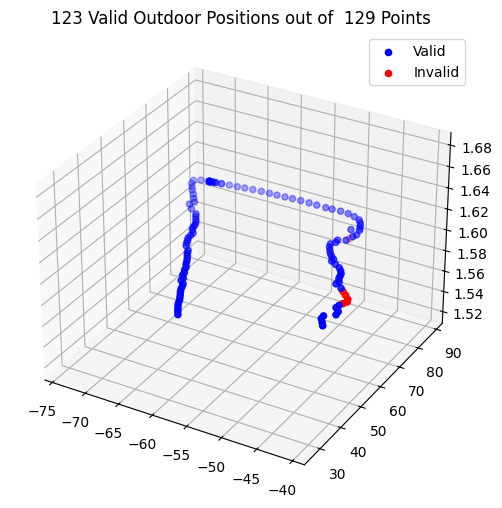

In [14]:
# Obtain the Mitsuba scene object from Sionna scene object 
mi_scene = scene.mi_scene

# Calculate scene bounding box excluding the ground plane
bbox = mi.ScalarBoundingBox3f()
for shape in mi_scene.shapes():
    if "ground" not in shape.id():
        bbox.expand(shape.bbox())

# Generate candidate positions (with a typical UE height of 1.5m)
# num_candidates = 1000
candidates = np.column_stack([
    merged_df["Sionna_Rx_x"].to_numpy(),
    merged_df["Sionna_Rx_y"].to_numpy(),
    merged_df["RxData_Rxh_m"].to_numpy()
])

# Create a direction vector pointing upwards (towards the sky) 
#  and tile it to match the number of positions
directions_np = np.tile(np.array([0, 0, 1]), (len(merged_df), 1))

# Ray tracing validation
rays = mi.Ray3f(
    mi.Vector3f(candidates),
    mi.Vector3f(directions_np)
)
si = mi_scene.ray_intersect(rays)
valid_mask = ~si.is_valid()

merged_df["is_outdoor"] = valid_mask

# Filter and visualize
valid_positions = candidates[valid_mask]
invalid_positions = candidates[~valid_mask]
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(valid_positions[:,0], valid_positions[:,1], valid_positions[:,2],c="blue",label="Valid")
ax.scatter(invalid_positions[:,0], invalid_positions[:,1], invalid_positions[:,2], c="red", label="Invalid" )
# Add legend
ax.legend()
ax.set_title(f"{len(valid_positions)} Valid Outdoor Positions out of  {len(merged_df)} Points")
plt.show()

### **Configure** the transmitters (TXs) and receivers (RXs)

Next, we specify:
1. The **transmit (TX)** antenna array is a planar array with a single element and isotropic pattern;
2. The **receive (RX)** antenna array is a planar array with a single element but with a dipole pattern.

Then, we create a `Transmitter` object with a specific position and orientation, and add it to the `scene`. Then, 10 valid RX locations from the above step are randomly selected.

**Note: Scene geographical coordinate system**
- Coordinate system: The center of the scene is at (0,0,0), the z-axis for the flat ground polygon is 0.
- Units: Meters (m).

**Note: Sionna Azimuth/Elevation Format**
- Sionna defines the **antenna azimuth** in the range [-π, π) [rad]. The following code converts the commonly used **north-origin, clockwise-degree azimuth** to the formate suitable for Sionna. Check the code below for details.

In [15]:
# Transmitter array (single isotropic element)
scene.tx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="iso",        # isotropic pattern
    polarization="V"      # vertical polarization
)

# Receive array (single dipole element)
scene.rx_array = PlanarArray(
    num_rows=1,
    num_cols=1,
    vertical_spacing=0.5,
    horizontal_spacing=0.5,
    pattern="dipole",
    polarization="V"
)

# Select 10 receivers form valid_positions (Outdoor positions)
# // for i, pos in enumerate(valid_positions[np.random.choice(valid_positions.shape[0], size=5, replace=False)]):
for index, row in merged_df.iterrows():
    if index <= 10:
        rx = Receiver(
            name=f"rx_{index}",
            position=(row["Sionna_Rx_x"], row["Sionna_Rx_y"] , row["RxData_Rxh_m"]),
            orientation=[0, 0, 0] 
        )
        scene.add(rx)

# Transmitter configuration
tx = Transmitter(
    name="tx",
    position=[0, 0, merged_df.iloc[0]["TxData_Txh_m"]],  # Elevated position
    orientation=[0, 0, 0]  
)
scene.add(tx)

# Validate setup
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

### **Compute** path (rays) for each TX-RX pair

- `max_depth=3` (maximum number of reflections/refractions/diffractions);
- `diffraction=True` to include diffraction effects;
- `scattering=True` to include scattering effects;
- `scat_keep_prob` specifies the probability with which a scattered path is kept;
- `num_samples=int(1e6)` specifies how many rays are sampled (reduce if running out of memory).

**Note**:
Reduce the number of samples if you observe out-of-memory error.

In [16]:
# Configure simulation parameters
scene.frequency = 28.5e9  
scene.synthetic_array = True  # Optimize for array calculations

# Perform ray tracing
paths = scene.compute_paths(
    max_depth=3,
    diffraction=True,
    scattering=True,
    scat_keep_prob=0.0001,
    num_samples=1e6, 
)

### **Visualize** the paths (rays) using Sionna built-in functions

In [17]:
# Preview the scene with paths
scene.preview(paths, show_paths=True)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…

## 4. **Performance Analysis**


### **Save** the raw information for individual rays
- `a`: Complex-valued path gain;
- `tau`: Path delay;
- `phi/theta`: Azimuth/elevation angles;
- `type`: LoS/Reflected/Diffracted/Scattered.

In [19]:
# Convert paths to analyzable format
ray_data = paths.to_dict()

# Create structured dataset
def create_ray_dataset(ray_dict, frequency):
    """Process raw ray data into pandas DataFrame"""
    dataset = {
        'freq': [],
        'rx_id': [],
        'type': [],
        'phi_r': [],
        'phi_t': [],
        'theta_r': [],
        'theta_t': [],
        'a':[],
        'tau':[],
        # 'rx_coord':[]
    }
    
    type_map = {0: "LoS", 1: "Reflected", 2: "Diffracted", 3: "Scattered"}
    
    a = ray_dict["a"].numpy().squeeze()
    tau = ray_dict["tau"].numpy().squeeze()
    types = ray_dict["types"].numpy().squeeze()
    mask = ray_dict["mask"].numpy().squeeze()
    phi_r = ray_dict["phi_r"].numpy().squeeze()
    phi_t = ray_dict["phi_t"].numpy().squeeze()
    theta_r = ray_dict["theta_r"].numpy().squeeze()
    theta_t = ray_dict["theta_t"].numpy().squeeze()
    
    # Extract relevant parameters
    for idx, item in enumerate(mask):
        
        # Filter out the RX which have no rays related
        if np.sum(item==True):
            for sub_idx, sub_item in enumerate(item):
                if sub_item:
                    dataset["type"].append(type_map[types[sub_idx]])
                    dataset["a"].append(a[idx,sub_idx])
                    dataset["tau"].append(tau[idx,sub_idx])
                    dataset["freq"].append(frequency)
                    
                    # Store the list instead of np.array to avoid the space sepreator in csv
                    #dataset["rx_coord"].append(valid_positions[idx].tolist())
                    dataset["phi_r"].append(phi_r[idx,sub_idx ])
                    dataset["phi_t"].append(phi_t[idx,sub_idx])
                    dataset["theta_r"].append(theta_r[idx,sub_idx])
                    dataset["theta_t"].append(theta_t[idx,sub_idx])
                    dataset["rx_id"].append(idx)

    return pd.DataFrame(dataset)

# Generate analysis dataframe
df = create_ray_dataset(ray_data, frequency=28e9)
df.head()

,freq,rx_id,type,phi_r,phi_t,theta_r,theta_t,a,tau
0,2.800000e+10,0,Reflected,-1.043566,-1.561786,1.562924,1.578669,-0.000003+0.000000j,1.836863e-07
1,2.800000e+10,0,Reflected,-2.271482,2.796769,1.560784,1.580808,-0.000005+0.000000j,1.022096e-07
2,2.800000e+10,0,Reflected,-0.332910,2.828147,1.561232,1.580361,0.000002-0.000000j,1.162381e-07
3,2.800000e+10,0,Reflected,-1.043566,-1.561786,1.606647,1.606647,0.000003+0.000000j,1.839197e-07
4,2.800000e+10,0,Reflected,-2.271482,2.796769,1.616377,1.616377,0.000004+0.000000j,1.025063e-07


### Compute path gain for RX

In [20]:
# Compute the absolute values of 'a' and sum by 'rx_id'
signal_strength = df.groupby('rx_id')['a'].apply(lambda x: 10 * np.log10(np.power(np.abs(x),2).sum())).reset_index()

# Rename the column for clarity
signal_strength.columns = ['rx_id', 'Path Gain']

signal_strength
# Merge the signal strength DataFrame with the measurement DataFrame
final_df = signal_strength.merge(merged_df, left_on='rx_id', right_index=True, how='left')

print(final_df.iloc[0].to_string())

rx_id                                                                           0
Path Gain                                                             -102.623968
file_name_x                                                           MPC2266.mat
mea_idx                                                                      2266
header_TxGainEffective_dBi                                                      2
header_TxHPBW_Effective_deg                                                  47.3
header_dist_m                                                           61.906189
header_NumSectors                                                               8
header_B2B_Attenuation_dB                                                     -15
MPC_params_sector01             [[194.60000000000002, 133.19305332, 11.0, 129....
MPC_params_sector02             [[194.60000000000002, 127.69305331999999, 12.0...
MPC_params_sector03             [[194.625, 129.19305332, 11.5, 128.64943718814...
MPC_params_secto

### Compute path gain for each sector

In [23]:
# Function to extract and sum the last values of each row's [n,4] arrays
def sum_last_values(row):
    return 10 * np.log10(sum(10 ** (arr[-1]/10) for arr in row))

# Apply function across rows
for sector_idx in range(1, 9, 1):
    final_df["MPC_params_sector0{}_sum_pg".format(sector_idx)] = final_df.apply(lambda row: sum_last_values(row["MPC_params_sector0{}".format(sector_idx)]), axis=1)

In [24]:
print(final_df.iloc[0].to_string())

rx_id                                                                           0
Path Gain                                                             -102.623968
file_name_x                                                           MPC2266.mat
mea_idx                                                                      2266
header_TxGainEffective_dBi                                                      2
header_TxHPBW_Effective_deg                                                  47.3
header_dist_m                                                           61.906189
header_NumSectors                                                               8
header_B2B_Attenuation_dB                                                     -15
MPC_params_sector01             [[194.60000000000002, 133.19305332, 11.0, 129....
MPC_params_sector02             [[194.60000000000002, 127.69305331999999, 12.0...
MPC_params_sector03             [[194.625, 129.19305332, 11.5, 128.64943718814...
MPC_params_secto

###  Performance Evaluation


In [25]:
# Calculate the total/outdoor-only RMSE
outdoor_df = final_df[final_df["is_outdoor"] == True]
for sector_idx in range(1, 9, 1):
    rmse = np.sqrt(((final_df['Path Gain'] - (-1*final_df['MPC_params_sector0{}_sum_pg'.format(sector_idx)]) + (np.mean((-1 *final_df['MPC_params_sector0{}_sum_pg'.format(sector_idx)] )) - np.mean(final_df['Path Gain']))) ** 2).mean())
    outdoor_rmse = np.sqrt(((outdoor_df['Path Gain'] - (-1*outdoor_df['MPC_params_sector0{}_sum_pg'.format(sector_idx)]) + (np.mean((-1 *outdoor_df['MPC_params_sector0{}_sum_pg'.format(sector_idx)] )) - np.mean(outdoor_df['Path Gain']))) ** 2).mean())

    print("Sector {} RMSE: {}".format(sector_idx, rmse))
    print(" Outdoor RMSE: {}".format(outdoor_rmse))
    print()

Sector 1 RMSE: 10.790280428159289
 Outdoor RMSE: 7.676643847481194

Sector 2 RMSE: 10.107227528398939
 Outdoor RMSE: 7.151451567072776

Sector 3 RMSE: 9.71981046473557
 Outdoor RMSE: 6.635687672524098

Sector 4 RMSE: 11.042638685394598
 Outdoor RMSE: 8.274485328347675

Sector 5 RMSE: 10.539929215300115
 Outdoor RMSE: 6.659030815368751

Sector 6 RMSE: 11.200305858819727
 Outdoor RMSE: 7.322937212226312

Sector 7 RMSE: 10.828997227975007
 Outdoor RMSE: 7.552057021786028

Sector 8 RMSE: 10.871489806714605
 Outdoor RMSE: 7.739920929441278

